# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import autokeras as ak
import tensorflow as tf
import pandas as pd

strategyArray  = []
gainArray      = []
lossArray      = []
channelTypeQnt = 3
ampNumber      = 3

originalDataSet = []
binaryDataSet   = []

gainScalerList = []
lossScalerList = []

originalDataSet.append(pd.read_csv('../datasets/1_channel_type/dataset-{}.txt'.format(ampNumber), sep = ',',header = None))
originalDataSet.append(pd.read_csv('../datasets/2_channel_type/dataset-{}.txt'.format(ampNumber), sep = ',',header = None))
originalDataSet.append(pd.read_csv('../datasets/4_channel_type/dataset-{}.txt'.format(ampNumber), sep = ',',header = None))

for i in range(channelTypeQnt):
    binaryDataSet.append([])
    for line in originalDataSet[i].values:
        myList = [1 if i != 0 else 0 for i in line[:40]]
        myList.extend(line[40:])
        binaryDataSet[i].append(myList)

    binaryDataSet[i] = pd.DataFrame(binaryDataSet[i])
    gainScaler       = MinMaxScaler(feature_range = (-1, 1))
    lossScaler       = MinMaxScaler(feature_range = (-1, 1))

    gainScalerAux = []
    lossScalerAux = []
    
    for j in range(0, ampNumber * 2, 2):
        gainScalerAux.extend(binaryDataSet[i].values[:, 40 + j])
        lossScalerAux.extend(binaryDataSet[i].values[:, 40 + j + 1])

    gainScaler.fit(np.array(gainScalerAux).reshape(-1, 1))
    lossScaler.fit(np.array(lossScalerAux).reshape(-1, 1))
    
    gainScalerList.append(gainScaler)
    lossScalerList.append(lossScaler)

def loadDataset(channelIndex): 
    dataSet = binaryDataSet[channelIndex].values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataSet[channelIndex].values[:, 40 + i])
        gain    = gainScaler.transform(gain.reshape(-1, 1))
        dataSet = np.hstack((dataSet, gain))
        
        loss    = np.array(binaryDataSet[channelIndex].values[:, 40 + i + 1])
        loss    = lossScaler.transform(loss.reshape(-1, 1))
        dataSet = np.hstack((dataSet, loss))
            
    X, y = np.array(dataSet[:, :40]), np.array(dataSet[:, 40:])
    return X, y

def invertGainNorm(value, channelIndex):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return gainScalerList[channelIndex].inverse_transform(auxArray)[0][0]

def invertLossNorm(value, channelIndex):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return lossScalerList[channelIndex].inverse_transform(auxArray)[0][0]
    
def getGainError(value1, value2, channelIndex):
    return (invertGainNorm(value1, channelIndex) - invertGainNorm(value2, channelIndex))**2

def getLossError(value1, value2, channelIndex):
    return (invertLossNorm(value1, channelIndex) - invertLossNorm(value2, channelIndex))**2

X, y = loadDataset(0)

# Cross validation function

In [2]:
def crossValidate(regressor, X, y, folds = 5):
    foldSize   = math.ceil(X.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(X, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(y, np.s_[sliceBegin: sliceEnd], 0)
        
        if isinstance(regressor, Sequential):
            regressor.fit(X_train, y_train, epochs = 500, verbose = 0)  
        else:
            regressor.fit(X_train, y_train)
            
        X_test = X[sliceBegin: sliceEnd]
        y_test = y[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            for i in range(0, ampNumber * 2, 2):
                gainError += getGainError(predicted[i], expected[i], 0) 
                lossError += getLossError(predicted[i + 1], expected[i + 1], 0)
                 
        gainErrors.append(gainError / foldSize)
        lossErrors.append(lossError / foldSize) # average loss error by amp
        
    return np.array(gainErrors), np.array(lossErrors)

In [3]:
def trainModel(strategy, channelIndex):   
    features, result       = loadDataset(channelIndex)
    gainErrors, lossErrors = crossValidate(strategy, features, result)

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (math.sqrt(np.mean(gainErrors)), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (math.sqrt(np.mean(lossErrors)), lossErrors.std() * 2))
    
    gainArray[channelIndex].append(gainErrors)
    lossArray[channelIndex].append(lossErrors)
    
    return gainErrors, lossErrors

In [4]:
def setANN():
    model = Sequential()
    
    model.add(Dense(4, input_dim = 4, kernel_initializer = 'random_uniform', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid')) 
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(4, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(2, kernel_initializer = 'random_uniform', activation = 'relu'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Plotting functions

In [5]:
def plotErrorBoxPlots():
    fig, axis = plt.subplots(2, 3, figsize = (10, 5))
    
    p1 = axis[0, 0].boxplot(np.sqrt(gainArray[0]))
    axis[0, 0].set_ylabel("Gain error (dB)", fontsize = 8)
    axis[0, 0].set_ylim([1, 8])
    
    axis[0, 1].boxplot(np.sqrt(gainArray[1]))
    axis[0, 1].set_ylim([1, 8])
    
    axis[0, 2].boxplot(np.sqrt(gainArray[2]))
    axis[0, 2].set_ylim([1, 8])
    
    axis[1, 0].boxplot(np.sqrt(lossArray[0]))
    axis[1, 0].set_ylabel("Loss error (dB)", fontsize = 8)
    axis[1, 0].set_xlabel("1 channel type", fontsize = 8)
    axis[1, 0].set_ylim([1, 8])
    
    axis[1, 1].boxplot(np.sqrt(lossArray[1]))
    axis[1, 1].set_xlabel("2 channel type", fontsize = 8)
    axis[1, 1].set_ylim([1, 8])
    #axis[1, 1].get_yaxis().set_visible(False)
    
    axis[1, 2].boxplot(np.sqrt(lossArray[2]))
    axis[1, 2].set_xlabel("4 channel type", fontsize = 8)
    axis[1, 2].set_ylim([1, 8])
    #axis[1, 2].get_yaxis().set_visible(False)
    
    fig.suptitle("Train error", fontsize = 16)
    fig.legend(p1["boxes"], strategyArray, handlelength = 0, bbox_to_anchor=(0.7, 0.81), loc = "right")
    
    #fix scale
    
    plt.show()

In [6]:
def plotGainDistribution(regressor):
    return
    features, result = loadDataset(channelIndex)

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))
    vFunc     = np.vectorize(invertGainNorm)
    
    axis.scatter(vFunc(result[:, 0], 0), vFunc(predicted[:, 0], 0))
    axis.set_title("Gain Distribution")
    axis.set_xlabel("Expected")
    axis.set_ylabel("Predicted")

    plt.show()

In [7]:
def plotLossDistribution(regressor):
    return
    features, result = loadDataset(0)

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))
    vFunc     = np.vectorize(invertLossNorm)
    
    axis.scatter(vFunc(result[:, 1], 0), vFunc(predicted[:, 1], 0), c = "m")
    axis.set_title("Loss Distribution")
    axis.set_xlabel("Expected")
    axis.set_ylabel("Predicted")

    plt.show()

# Putting all together

In [8]:
gainArray = [[],[],[]]
lossArray = [[],[],[]]

In [9]:
for i in range(channelTypeQnt):
    linearSVR = MultiOutputRegressor(SVR(kernel = "rbf", C = 1.0, gamma = 'scale', epsilon = 0.2))
    trainModel(linearSVR, i)
    
strategyArray.append("1 - SVR (Linear)")
plotGainDistribution(linearSVR)
plotLossDistribution(linearSVR)

[48.39463614 11.41665525 12.71072529 36.09681601 23.36250845] => 5.14 (+/- 28.27)
[29.62409537 27.86826932 26.69455941 19.9587806  16.45084629] => 4.91 (+/- 10.08)
[23.18110175 38.15743103 20.33044907 12.63405412 10.30476853] => 4.57 (+/- 19.68)
[25.85943653 27.1684402  22.88322002 37.36454429  9.34571167] => 4.95 (+/- 18.04)
[26.76644731 19.07733547 10.980925   21.58468461 14.23593474] => 4.30 (+/- 11.06)
[24.59173477 26.66061624 18.94917707 22.47428745 22.46494029] => 4.80 (+/- 5.13)


In [10]:
for i in range(channelTypeQnt):
    lasso = MultiOutputRegressor(linear_model.Lasso(alpha = 0.2))
    trainModel(lasso, i)
    
strategyArray.append("2 - Lasso")
plotGainDistribution(lasso)
plotLossDistribution(lasso)

[28.35758673 35.15468408 24.52115097 33.6035125  25.48174433] => 5.42 (+/- 8.53)
[20.64481676 29.31131248 21.95279513 19.49390063 11.92485174] => 4.55 (+/- 11.11)
[22.38592276 42.08578189 18.22291562 15.12770654 11.89064667] => 4.68 (+/- 21.30)
[32.99670783 29.11514133 28.94759098 31.94893219 14.16967117] => 5.24 (+/- 13.63)
[26.8929541  27.85982626 19.47193507 25.85676239 26.03656892] => 5.02 (+/- 5.92)
[27.69453049 31.04620101 21.13511816 22.46734069 23.39904465] => 5.01 (+/- 7.36)


In [11]:
for i in range(channelTypeQnt):
    lars = MultiOutputRegressor(linear_model.Lars(n_nonzero_coefs=1))
    trainModel(lars, i)
    
strategyArray.append("3 - LARS")
plotGainDistribution(lars)
plotLossDistribution(lars)

[36.50462786 36.06191104 24.34177881 33.99023341 26.16331972] => 5.60 (+/- 10.27)
[26.94168393 28.31317062 22.10644103 19.43598476 12.91355028] => 4.68 (+/- 11.08)
[21.22233193 37.5048983  17.49856612 14.62649194 11.50302493] => 4.52 (+/- 18.20)
[32.18090964 28.13011921 26.81214171 30.34765913 11.91058871] => 5.09 (+/- 14.44)
[26.94558947 24.9833046  16.19380991 23.73872491 24.74033287] => 4.83 (+/- 7.42)
[22.86710373 25.48068738 15.94687676 19.57619372 22.45983556] => 4.61 (+/- 6.51)


In [12]:
for i in range(channelTypeQnt):
    huber = MultiOutputRegressor(linear_model.HuberRegressor(max_iter = 10000))
    trainModel(huber, i)
    
strategyArray.append("4 - Huber")
plotGainDistribution(huber)
plotLossDistribution(huber)

[49.60357054 10.16068896  9.29410976 44.17982635 40.3361155 ] => 5.54 (+/- 34.78)
[49.37597903 26.28729557 25.24729834 18.80702668 20.74427506] => 5.30 (+/- 21.99)
[27.05396395 48.61657861 20.58202927 48.46255489 63.24795839] => 6.45 (+/- 31.22)
[33.00633226 46.66127232 21.08169561 36.23504037 27.36211007] => 5.73 (+/- 17.22)
[89.75779466 27.18997985 72.71671346 18.80161166 40.86212109] => 7.06 (+/- 54.21)
[97.89459387 62.18127121 46.01354972 28.92583664 30.05081553] => 7.28 (+/- 51.03)


In [13]:
for i in range(channelTypeQnt):
    knn = MultiOutputRegressor(KNeighborsRegressor())
    trainModel(knn, i)
    
strategyArray.append("5 - KNN")
plotGainDistribution(knn)
plotLossDistribution(knn)

[53.98482759  7.71751724 11.25765517 43.3862069  33.33517241] => 5.47 (+/- 35.93)
[28.92069817 28.8973759  17.98996679 18.4638229  19.20621201] => 4.76 (+/- 10.18)
[26.42025316 33.95868354 21.89711392 15.54987342 20.03301266] => 4.86 (+/- 12.51)
[29.16783747 24.40213283 25.97621878 42.5804932  44.84412689] => 5.78 (+/- 17.19)
[63.57830508 29.77265537 12.61762712 46.68892655 13.1060452 ] => 5.76 (+/- 39.44)
[25.86145498 44.3515045  22.35719049 26.10335775 15.55927181] => 5.18 (+/- 19.09)


In [14]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

for i in range(channelTypeQnt):
    extra_tree = ExtraTreeRegressor(criterion = "mse", random_state=0)
    bret = MultiOutputRegressor(BaggingRegressor(base_estimator = extra_tree, n_estimators = 100, random_state = 0))
    trainModel(bret, i)
    
strategyArray.append("6 - Extra Tree")
plotGainDistribution(bret)
plotLossDistribution(bret)

[61.89804585  7.63944825  9.82280915 45.05406888 36.40920545] => 5.67 (+/- 41.65)
[32.6289817  25.04451429 22.52939494 18.49658726 18.17029164] => 4.83 (+/- 10.58)
[27.33290024 45.81648492 18.12356384 11.18184345  6.83094445] => 4.68 (+/- 27.68)
[28.13954917 24.79029348 19.40752235 37.34618048  8.31069622] => 4.86 (+/- 19.23)
[50.57101677 17.21890493  8.01942243 27.37415411 12.63342211] => 4.81 (+/- 30.26)
[30.20938548 24.78491623 18.93156977 21.87843821 20.04932619] => 4.81 (+/- 8.08)


In [15]:
from sklearn.ensemble import RandomForestRegressor

for i in range(channelTypeQnt):
    randomForest = RandomForestRegressor(max_depth = 8, random_state = 0, n_estimators = 100)
    trainModel(randomForest, i)

strategyArray.append("7 - Random Forest")
plotGainDistribution(randomForest)
plotLossDistribution(randomForest)

[61.89804585  7.63944825  9.83043314 44.60525369 36.40920545] => 5.66 (+/- 41.54)
[32.6289817  25.04451429 22.49909027 18.53468833 18.17029164] => 4.83 (+/- 10.57)
[26.5880764  46.09077038 17.94427193 11.22537931  6.92972194] => 4.66 (+/- 27.72)
[30.63526097 29.93262398 19.73981956 37.20207108  7.84204448] => 5.01 (+/- 20.53)
[53.52108999 17.26762275  9.27366657 27.91703197  9.60611141] => 4.85 (+/- 32.92)
[31.0811449  26.54668476 18.72689621 22.32742222 17.18340618] => 4.81 (+/- 10.21)


# Plotting error boxplots

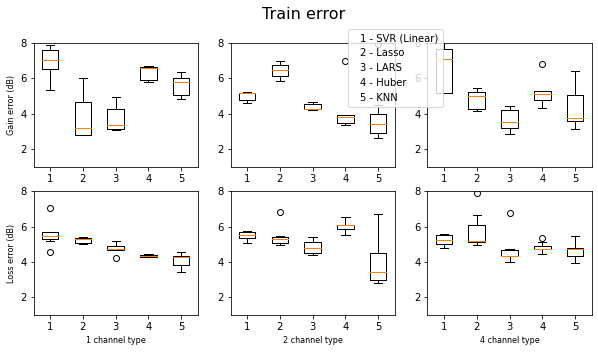

In [16]:
plotErrorBoxPlots()